In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import islets
from scipy.stats import distributions as dst
%config InlineBackend.figure_format='retina'
plt.rcParams["font.size"] = 16
from scipy.spatial import distance_matrix
import pandas as pd

# Regions

In [12]:
k = 11
th = k*.45

res = 64
np.random.seed(0)
points = (np.random.rand(200,2)*res).astype(int)
points = points[np.linalg.norm(points-np.repeat([[res/2]*2], len(points), axis=0),axis=1)<res/2]
while True:
    dd = distance_matrix(points, points)
    indices = np.array(np.triu_indices_from(dd,1)).T
    closest_neighbors = indices[dd[tuple(indices.T)]<th]
    if len(closest_neighbors)==0: break
    todel = pd.Series(closest_neighbors.flatten()).value_counts().index[0]
    points = points[[j!=todel for j in range(len(points))]]

image = np.zeros((res,res))
image[points.T[0], points.T[1]] = 500
m = islets.cmovie(image.reshape(1,res,res))
image = m.gaussian_blur_2D(k,k,k/6,k/6)[0].copy()
image = np.maximum(image, np.percentile(image[image>0],1))
real  = dst.poisson(mu=image+2+m.gaussian_blur_2D(k*2+1,k*2+1,-1,-1)[0]).rvs().astype(float)
vmax = islets.numeric.robust_max(real)//5*5

/opt/tljh/user/envs/physio_dev/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator


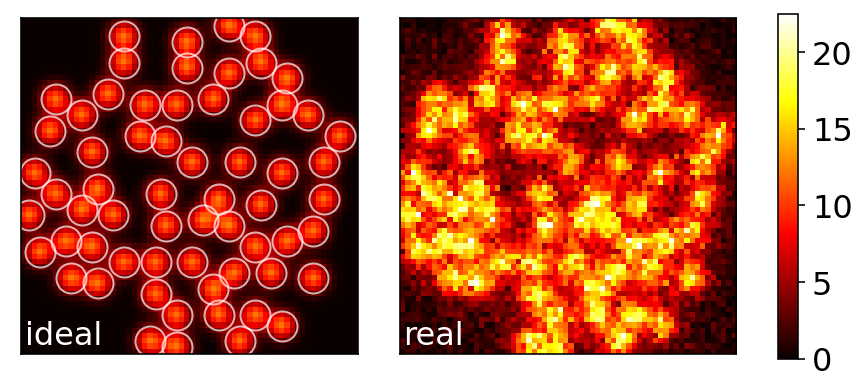

In [13]:
fig, axs = plt.subplots(1,3,figsize=(6.3,3), gridspec_kw={"width_ratios":[1,1,.06]})

for ax in axs[:-1]:
    ax.set_xticks([])
    ax.set_yticks([])
ax = axs[0]
ax.plot(points.T[1],points.T[0],"wo", mfc="none", ms=15, alpha = .7)
ax.text(0.01,.03,"ideal", transform=ax.transAxes, color="w")
im = ax.imshow(image, cmap="hot", vmax=vmax, vmin=0)
cticks = range(0,41,5)
cbar = plt.colorbar(im, cax=axs[-1], 
#                     ticks=cticks
                   )
ax = axs[1]
ax.text(0.01,.03,"real", transform=ax.transAxes, color="w")
ax.imshow(real, cmap="hot",  vmax=vmax, vmin=0)
cbar.ax.set_yticklabels([str(i) for i in cticks])  # vertically oriented colorbar
plt.tight_layout()
plt.savefig("figures/regions_ideal_real.pdf")

In [14]:
k0 = int(k/2)+1
k0

6

In [15]:
ks = [int(k0*.6//2*2+1),int(k0*1.7/2)*2+1,k0//2*2+1]
ks

[3, 11, 7]

In [16]:
blur = {}
bkg  = {}
regions = {}
for ir,kk in enumerate(ks):
    blur[kk] = islets.cmovie(real.copy().reshape(1,res,res)).gaussian_blur_2D(kk,kk,-1,-1)[0]
    bkg[kk]  = islets.cmovie(real.copy().reshape(1,res,res)).gaussian_blur_2D(kk*2+1,kk*2+1,-1,-1)[0]
    dimage = blur[kk]-bkg[kk]
    dimage = dimage/islets.numeric.robust_max(dimage)
    regions[kk] = islets.Regions(dimage,mode="custom", verbose=True)

Initiating from an image, with a mode custom
dilating valid pixels by 3
initiating the cralwing dict with 2028 pixels excluded.
entering crawling dict with 2028 pixels excluded.
Crawling the image with 2028 pixels excluded.
Initiating from an image, with a mode custom
dilating valid pixels by 3
initiating the cralwing dict with 1813 pixels excluded.
entering crawling dict with 1813 pixels excluded.
Crawling the image with 1813 pixels excluded.
Initiating from an image, with a mode custom
dilating valid pixels by 3
initiating the cralwing dict with 1936 pixels excluded.
entering crawling dict with 1936 pixels excluded.
Crawling the image with 1936 pixels excluded.


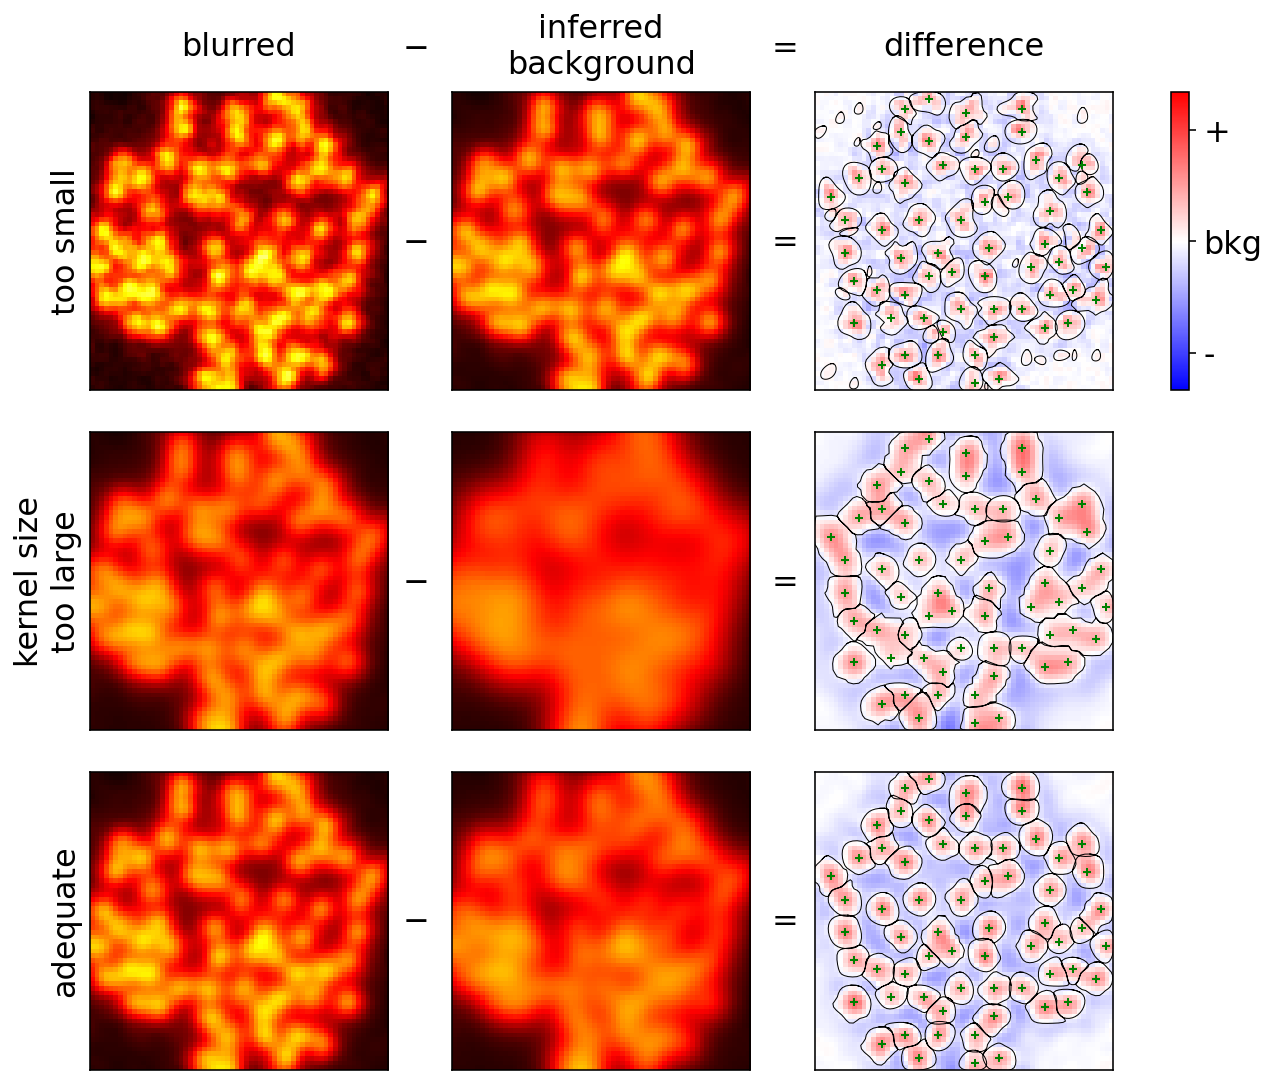

In [17]:
fig, axs = plt.subplots(3,4,figsize=(9,7.8), gridspec_kw={"width_ratios":[1,1,1,.06]})
for ir,kk in enumerate(blur):
    axr = axs[ir]
    axr[0].text(1.05,.5,r"$-$",transform=axr[0].transAxes, va="center",)
#     axr[0].set_ylabel(r"kernel = %i"%kk)
    txt = dict(zip(ks, ["too small","too large","adequate"]))[kk]
    axr[0].set_ylabel(txt)
    axr[1].text(1.05,.5,r"$=$",transform=axr[1].transAxes, va="center",)
    axr[0].imshow(blur[kk], cmap="hot", vmin=0, vmax=vmax)
    axr[1].imshow( bkg[kk], cmap="hot", vmin=0, vmax=vmax)
    dimage = blur[kk]-bkg[kk]
    dimage = dimage/islets.numeric.robust_max(dimage)
    im = axr[2].imshow(dimage, cmap="bwr",  vmax = 2,  vmin =-2)
    if ir==0:
        cbar = plt.colorbar(im, cax=axr[-1], ticks=[-1.5,0,1.5])
        cbar.ax.set_yticklabels(["-","bkg","+"])  # vertically oriented colorbar
    else:
        axr[-1].remove()
    for ax in axr[:-1]:
        ax.set_xticks([])
        ax.set_yticks([])
    
    regions[kk].plotEdges(ax=axr[2], image=False, color="k")
for ax,txt in zip(axs[0,:-1],["blurred","inferred\nbackground", "difference"]):
    ax.text(.5,1.15,txt, transform=ax.transAxes, va="center",ha="center")
axs[0,0].text(1.05,1.15,r"$-$",transform=axs[0,0].transAxes, va="center",)
axs[0,1].text(1.05,1.15,r"$=$",transform=axs[0,1].transAxes, va="center",)
for ax in axs[:,2]:
    ax.plot(points.T[1],points.T[0],"g+",ms=4)
ax = axs[1,0]
ax.text(-.2,.5,"kernel size",transform=ax.transAxes,va="center",ha="center", rotation=90)
plt.tight_layout()
axs[-1,2].plot(points.T[1],points.T[0],"g+",ms=4)
# fig.set_facecolor("y")
plt.savefig("figures/regions_kernels.pdf")

# Pipeline

In [2]:
reg = islets.load_regions("small_example_rois.pkl")
reg.df = reg.df.loc[[122, 127, 132, 140, 155, 156, 163, 168, 169, 172, 189, 192, 195,
            196, 197, 199, 209, 210, 215, 222, 226, 234, 242, 245, 249, 261,
            262]]
reg.df.index = range(reg.df.shape[0])
reg.update()
reg.df["color"] = list(plt.cm.get_cmap("tab10")(reg.df.index%10))
reg.change_frequency(1)
reg.detrend_traces()

In [3]:
allpxs = sum(reg.df.pixels,[])

xlim = np.asarray(allpxs).T[1].min()-5, np.asarray(allpxs).T[1].max()+6
ylim = np.asarray(allpxs).T[0].min()-7, np.asarray(allpxs).T[0].max()+7

np.diff(xlim), np.diff(ylim)

(array([88]), array([88]))

In [4]:
im = np.log(reg.statImages["mean"]+2)

(9.5, 16.5)

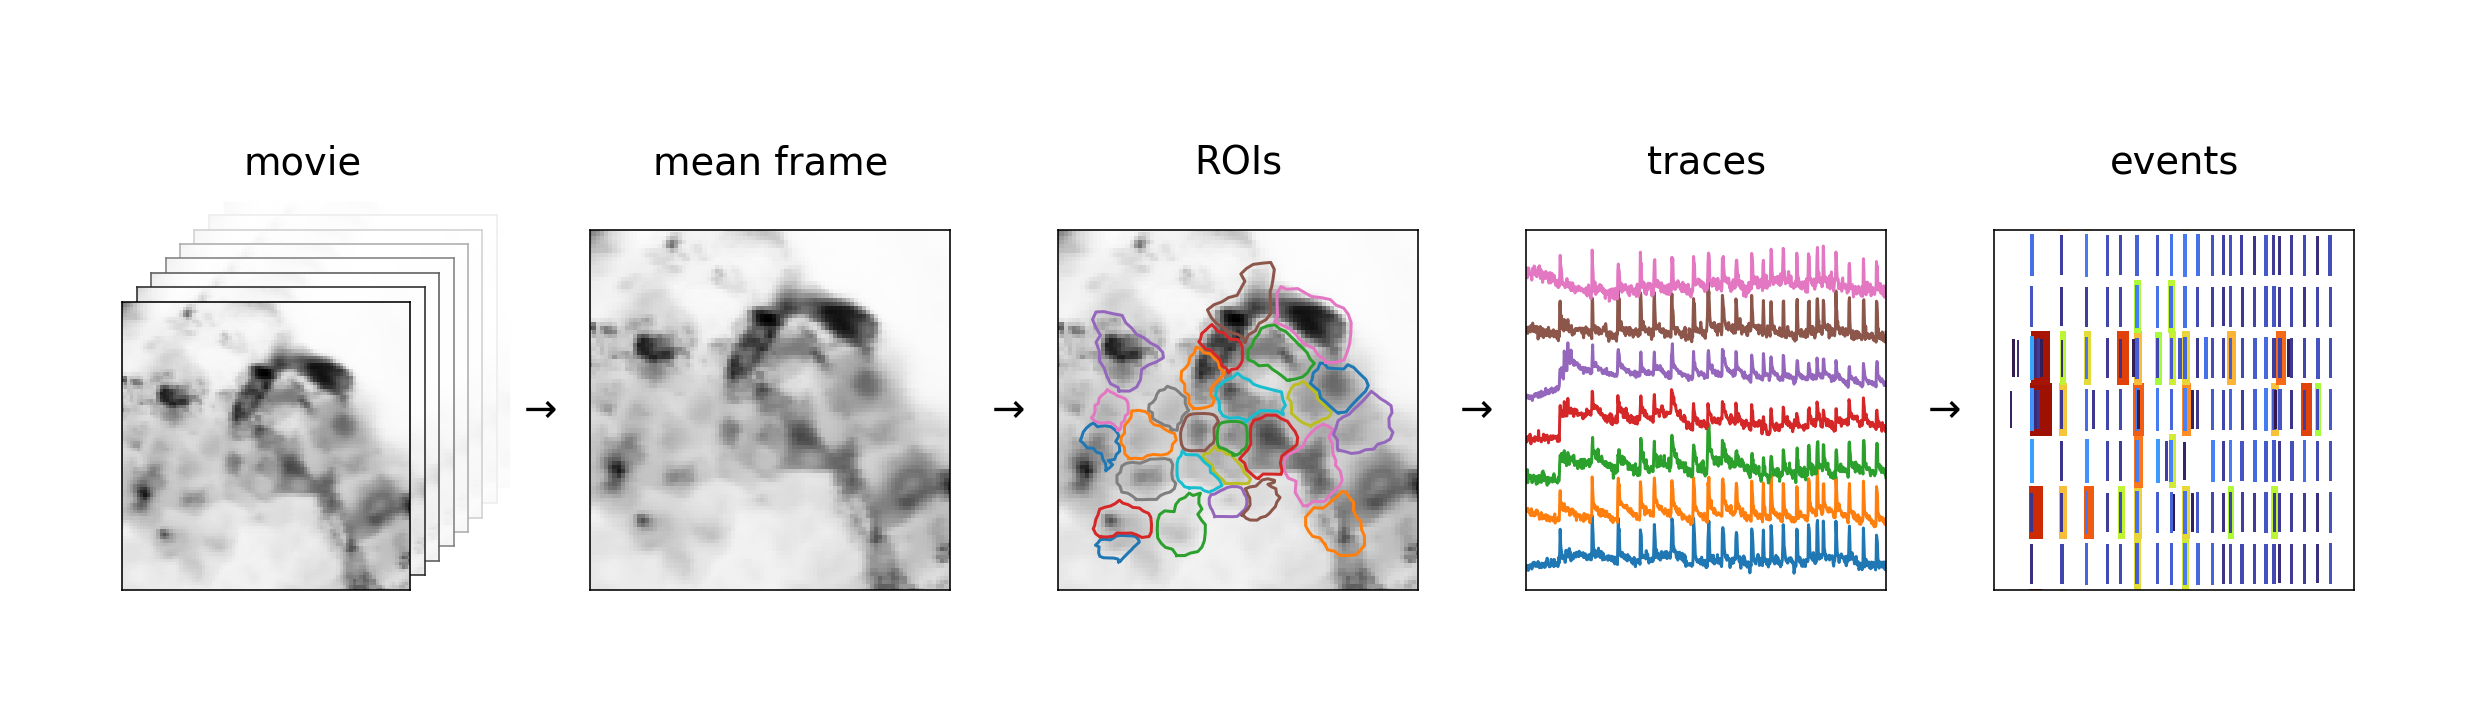

In [10]:
# ts = 3
# evs = reg.detect_events(ts,z_th=3, smooth=0)
evs = islets.EventDistillery.sequential_filtering(reg, timescales=[3,5,10,100], verbose=False)
alpha = .3
w,h = 5+6*alpha,1+3*alpha
fig = plt.figure(figsize=np.array([w,h])*2.5)
# fig.set_facecolor("g")
ax = fig.add_axes([0,0,1,1])
ax.set_xticks([])
ax.set_yticks([])
for sp in ax.spines: ax.spines[sp].set_visible(False)
axs = []
for j in range(5):
    ax = fig.add_axes([(alpha+j*(1+alpha))/w,alpha/h,1/w,1/h])
    if j<3 and j>0:
        ax.imshow(im, cmap="Greys")
    ax.set_xticks([])
    ax.set_yticks([])
    axs += [ax]
ax = axs[0]
for sp in ax.spines: ax.spines[sp].set_visible(False)
axm = []
for j in [7,6,5,4,3,2,1,0]:
    ax = fig.add_axes([(alpha+j*.04)/w,(alpha+j*.04)/h,.8/w,.8/h])
    for sp in ax.spines: ax.spines[sp].set_color(plt.cm.Greys(1-j/7))
    ax.imshow(im/(j+1), cmap="Greys",vmax=im.max())
    ax.set_xticks([])
    ax.set_yticks([])
    axm += [ax]
for j in range(1,5):
    fig.text((alpha/2+j*(1+alpha))/w,(alpha+.5)/h,r"$\rightarrow$",va="center",ha="center", fontsize=20)
# axs[0].remove()
reg.plotEdges(ax=axs[2],image=False, separate=True,lw=1.5, scaleFontSize=0)
for ax in axs[1:-2]+axm:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
for ax,text in zip(axs,["movie","mean frame","ROIs","traces","events"]):
    ax.set_title(text+"\n")
ax = axs[3]
indices = reg.df.index[10:-10]
for i in indices:
    x = reg.df.loc[i,"detrended"]
    x = x-x.mean()
    x = x/x.std()
    ax.plot(x+i*5)
ax.set_xlim(0,len(x))
islets.EventDistillery.plot_events(
    evs,
    ax=axs[-1],
    min_height=.7,
    xc=10
)
axs[-1].set_ylim(indices[0]-.5,indices[-1]+.5)

In [11]:
fig.savefig("figures/pipeline.pdf")